In [85]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import SnowballStemmer 
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet') 
nltk.download("stopwords")
#for model-building
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim import models, corpora
from gensim.models import Word2Vec
#for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
#for text clustering
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaustubh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kaustubh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kaustubh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaustubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
df = pd.read_csv("Airline_Tweets.csv")

In [87]:
df.head(10)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   
5  570300767074181121          negative                        1.0000   
6  570300616901320704          positive                        0.6745   
7  570300248553349120           neutral                        0.6340   
8  570299953286942721          positive                        0.6559   
9  570295459631263746          positive                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   
5     Can't Tell                     0.6842  Virgin America   
6            NaN                     0.0000  Virgin America   
7            NaN                        NaN  Virgin America   
8            NaN                        NaN  Virgin America   
9            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   
5                    NaN    jnardino                 NaN              0   
6                    NaN  cjmcginnis                 NaN              0   
7                    NaN       pilot                 NaN              0   
8                    NaN    dhepburn                 NaN              0   
9                    NaN  YupitsTate                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   
5  @VirginAmerica seriously would pay $30 a fligh...         NaN   
6  @VirginAmerica yes, nearly every time I fly VX...         NaN   
7  @VirginAmerica Really missed a prime opportuni...         NaN   
8    @virginamerica Well, I didn't…but NOW I DO! :-D         NaN   
9  @VirginAmerica it was amazing, and arrived an ...         NaN   

               tweet_created    tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800               NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800               NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800         Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800               NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800               NaN  Pacific Time (US & Canada)  
5  2015-02-24 11:14:33 -0800               NaN  Pacific Time (US & Canada)  
6  2015-02-24 11:13:57 -0800  San Francisco CA  Pacific Time (US & Canada)  
7  2015-02-24 11:12:29 -0800       Los Angeles  Pacific Time (US & Canada)  
8  2015-02-24 11:11:19 -0800         San Diego  Pacific Time (US & Canada)  
9  2015-02-24 10:53:27 -0800       Los Angeles  Eastern Time (US & Canada)

In [88]:
#The stuff about preprocessing

def preprocess(text): 
    text = text.lower() 
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) 
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip()) 
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text) 
    return text

def stopword(string):
    a= [i for i in string.split() 
    if i not in stopwords.words('english')]
    return ' '.join(a)

In [89]:
wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) 
    for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)


In [101]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
bdf['text2'] = bdf['text'].apply(lambda x: finalpreprocess(x)) 
df.head()

C:\Users\Kaustubh\AppData\Local\Temp\ipykernel_23900\864837826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf['text2'] = bdf['text'].apply(lambda x: finalpreprocess(x))


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [100]:
adf=df.copy()
bdf=adf[:1000]

In [41]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [96]:
stop_words=stopwords.words('english')
tokenized = sent_tokenize(text)

for i in tokenized:
    wordsList = nltk.word_tokenize(i)
    wordsList = [w for w in wordsList if not w in stop_words]
    tagged = nltk.pos_tag(wordsList)
    print(tagged)


[('v', 'NN'), ('r', 'NN'), ('g', 'NN'), ('n', 'NN'), ('e', 'NN'), ('r', 'NN'), ('c', 'NN'), ('h', 'NN'), ('e', 'NN'), ('p', 'NN'), ('b', 'NN'), ('u', 'JJ'), ('r', 'NN'), ('n', 'NN'), ('v', 'NN'), ('r', 'NN'), ('g', 'NN'), ('n', 'NN'), ('e', 'NN'), ('r', 'NN'), ('c', 'NN'), ('p', 'NN'), ('l', 'NN'), ('u', 'JJ'), ('e', 'NN'), ('c', 'NN'), ('e', 'NN'), ('r', 'NN'), ('c', 'NN'), ('l', 'NN'), ('e', 'NN'), ('x', 'NNP'), ('p', 'NN'), ('e', 'NN'), ('r', 'NN'), ('e', 'NN'), ('n', 'JJ'), ('c', 'NN'), ('e', 'NN'), ('c', 'VBP'), ('k', 'NN'), ('v', 'NN'), ('r', 'NN'), ('g', 'NN'), ('n', 'NN'), ('e', 'NN'), ('r', 'NN'), ('c', 'NN'), ('u', 'JJ'), ('e', 'NN'), ('n', 'JJ'), ('n', 'JJ'), ('e', 'NN'), ('e', 'NN'), ('k', 'NN'), ('e', 'FW'), ('n', 'JJ'), ('h', 'NN'), ('e', 'NN'), ('r', 'NN'), ('r', 'NN'), ('p', 'NN'), ('v', 'NN'), ('r', 'NN'), ('g', 'NN'), ('n', 'NN'), ('e', 'NN'), ('r', 'NN'), ('c', 'NN'), ('r', 'NN'), ('e', 'NN'), ('l', 'NN'), ('l', 'NN'), ('g', 'NN'), ('g', 'NN'), ('r', 'NN'), ('e', 'NN

In [103]:
bdf['text2']

0                             virginamerica dhepburn say
1      virginamerica plus added commercial experience...
2      virginamerica today must mean need take anothe...
3      virginamerica really aggressive blast obnoxiou...
4                     virginamerica really big bad thing
                             ...                        
995    united time finally get dallas could drive les...
996    united try get final destination need compensa...
997    united guy really customer service clue could ...
998                                 united priority iove
999                       united please premier platinum
Name: text2, Length: 1000, dtype: object

In [93]:
from wordcloud import WordCloud

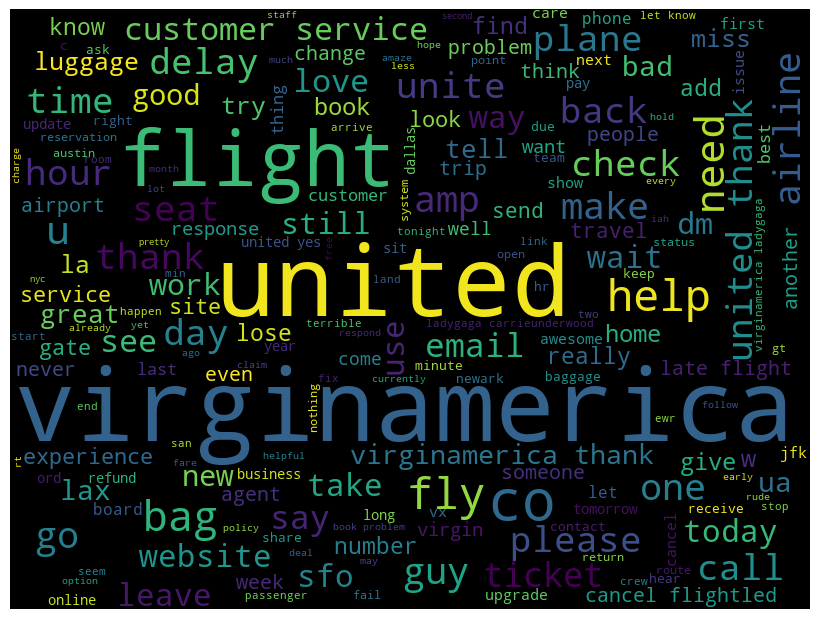

In [104]:
text = ' '.join(bdf['text2'].astype(str))
wordcloud=WordCloud(width=800, height=600).generate(text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [71]:
tfidfvectroizer=TfidfVectorizer(use_idf=True) #splitting the text into train and test data
X_train, X_test, y_train, y_test= train_test_split(df['text'],df['airline_sentiment'], test_size=0.2, shuffle=True) 
X_train_vectors=tfidfvectroizer.fit_transform(X_train)
X_test_vectors=tfidfvectroizer.transform(X_test)



# vectorizer = CountVectorizer(stop_words='english') #Without separately removing stop words
# X_train_vectors = vectorizer.fit_transform(X_train)

In [72]:
#Logistic Regression
#Naive Bayes
model=MultinomialNB()
model.fit(X_train_vectors, y_train)

MultinomialNB()

In [91]:
print(model.score(X_test_vectors, y_test))

0.6861338797814208


In [76]:
y_pred= model.predict(X_test_vectors) #Predicting values
y_prob = model.predict_proba(X_test_vectors)[:,1] #Predicting Probabilities

In [78]:
tp=pd.DataFrame()
tp['Predicted'] = y_pred
tp['Actuality'] = y_test

display(tp)

confusion_matrix(y_test, y_pred) #Confusion Matrix


Predicted Actuality
0     negative   neutral
1      neutral       NaN
2     positive   neutral
3     positive       NaN
4     negative       NaN
...        ...       ...
2923  positive       NaN
2924  negative       NaN
2925  negative       NaN
2926  negative  negative
2927  negative       NaN

[2928 rows x 2 columns]

array([[1813,    7,    2],
       [ 522,   99,    7],
       [ 362,   19,   97]], dtype=int64)

In [84]:
y_prob = model.predict_proba(X_test_vectors)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob) #ROC/AUC
roc_auc = auc(fpr, tpr) 
print('AUC:', roc_auc)

ValueError: multiclass format is not supported